# Learning with the newspapers 📰

## Introduction

The primary objective of this data science project is to build a text classification model capable of  predicting the newspaper that published them. Being able to attribute articles to their respective newspapers can have practical applications in content analysis and media scoring.

In this project, we will leverage natural language processing techniques and machine learning algorithms to develop an accurate language and newspaper classification model. By the end of this notebook, we aim to create two models that can help us predict the target class. We goal of this notebook is to show the step necessary to create a machine learning pipeline


In [1]:
import pandas as pd

In [2]:
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords','/work/')
nltk.download('wordnet','/work/')
nltk.download('omw-1.4','/work/')
nltk.data.path.append("/work/")
print(stopwords.fileids())

# Downloading the stopwords for English in order to simplify the text
stopwords_both = set(stopwords.words('english'))

ModuleNotFoundError: No module named 'nltk'

## Data Collection and Preprocessing

To achieve our goal, we have a labeled dataset that includes news articles written in both English and Japanese, along with the information about the newspaper source for each article. The data will be collected from reliable news websites and public datasets, with the necessary metadata for each article.

Before training the classification model, we need to preprocess the textual data. This preprocessing step involves removing irrelevant information such as HTML tags, special characters, and punctuation. Additionally, we will convert all text to lowercase to ensure consistent and case-insensitive feature extraction.

In [31]:
def collect_data():
    english_news_df = pd.read_csv('./archive/english_news.csv',delimiter='\t')
    japanese_news_df = pd.read_csv('./archive/japanese_news.csv',delimiter='\t')
    
    # Add a 'language' column to each DataFrame to indicate the language
    english_news_df['language'] = 'English'
    japanese_news_df['language'] = 'Japanese'
    
    # Concatenate the two DataFrames into one
    combined_df = pd.concat([english_news_df, japanese_news_df], ignore_index=True).reset_index()
    
    return combined_df

# Call the data collection function to get the DataFrame
news_df = collect_data()

/var/folders/6w/gz9n0yls06x2trmh5ghyvzgc0000gn/T/ipykernel_47476/1627910504.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  japanese_news_df = pd.read_csv('./archive/japanese_news.csv',delimiter='\t')


In [ ]:
import string as sss
def clean_to_list(text):
    text_data = re.sub('[^a-zA-Z]', ' ', text)
    text_data = text_data.lower()
    text_data = text_data.split()
    wl = WordNetLemmatizer()
    text_data = [wl.lemmatize(word) for word in text_data if not word in stopwords_both]
    return ' '.join(text_data)


def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    text = text.lower()
    
    # Remove HTML tags (if any)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and punctuation
    text = text.translate(str.maketrans('', '', sss.punctuation))
    
    #Clean via nltk: remove stopwords and lemmatize
    return clean_to_list(text)


# Apply preprocessing to the 'article_text' column in the DataFrame
news_df.loc[:,'preprocessed_text'] = news_df['text'].apply(preprocess_text)
news_df.loc[:,'preprocessed_title'] = news_df['title'].apply(preprocess_text)

(349844, 7)


In [ ]:
news_df.describe(include='all')

,index,source,date,title,author,text,language,preprocessed_text,preprocessed_title
count,349844.000000,349844,349844,36928,12847,349720,349844,349844,349844
unique,NaN,23,2711,36098,1318,348886,2,38748,35992
top,NaN,mainichi.jp,2011-10-28,KANSAI: Who & What,Philip Brasor,This could be due to a conflict with your ad-b...,Japanese,,
freq,NaN,44657,7974,23,318,5,312955,309258,312959
mean,174921.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,100991.408125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,87460.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,174921.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,262382.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration and Visualization

Before diving into model building, it is essential to gain insights into the dataset. We will visualize the distribution of news articles from different newspapers and their corresponding languages. Understanding the class balance will help us identify potential biases and address any data-related challenges.

Furthermore, we will analyze the length of the articles and the distribution of words to gather valuable information that may impact our classification model's performance.

Let's begin by collecting and preprocessing the data, followed by exploratory data analysis to prepare our data for the language and newspaper classification task.

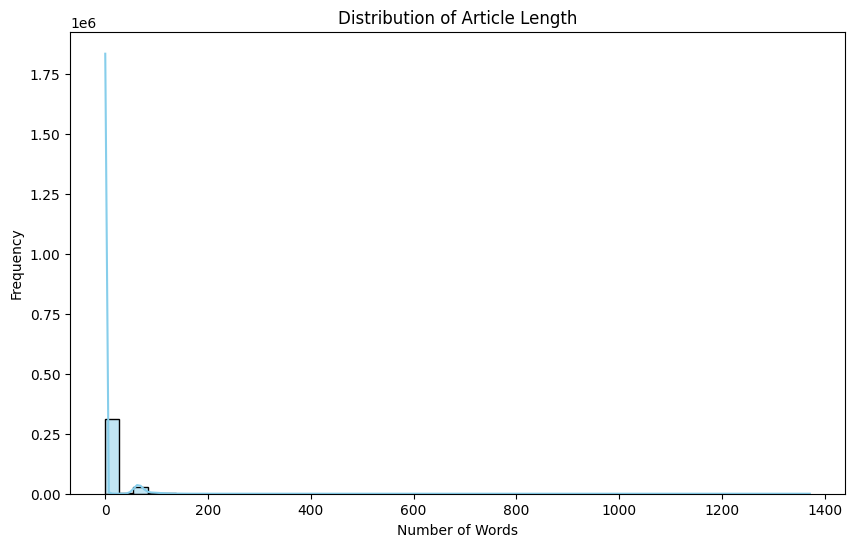

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to analyze the article length and word distribution
def analyze_article_length(data_df):
    data_df['article_length'] = data_df['preprocessed_text'].apply(lambda x: len(x.split()))
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data_df['article_length'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Article Length')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

analyze_article_length(news_df)

In [ ]:
def plot_articles_per_author(data_df):
    # Fill missing author values with "Unknown"
    data_df['author'].fillna("Unknown", inplace=True)

    # Group the DataFrame by 'author' and 'source', and count the number of articles for each combination
    author_source_counts = data_df.groupby(['author', 'source']).size().reset_index(name='article_count')

    # Create a pivot table to reshape the data for plotting
    pivot_table = author_source_counts.pivot_table(index='author', columns='source', values='article_count', fill_value=0)

    # Plot the bar chart
    pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))

    # Set plot labels and title
    plt.xlabel('Author')
    plt.ylabel('Number of Articles')
    plt.title('Number of Articles Written by Each Author for Each Source')

    # Display the plot
    plt.show()

#plot_articles_per_author(news_df)

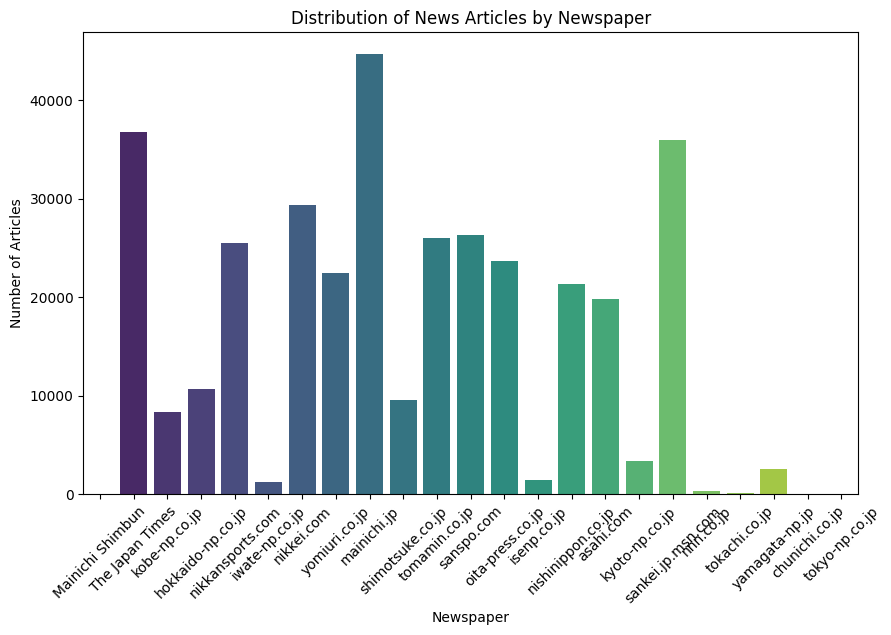

In [ ]:
def plot_newspaper_distribution(data_df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='source', data=data_df, palette='viridis')
    plt.title('Distribution of News Articles by Newspaper')
    plt.xlabel('Newspaper')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45)
    plt.show()

plot_newspaper_distribution(news_df)

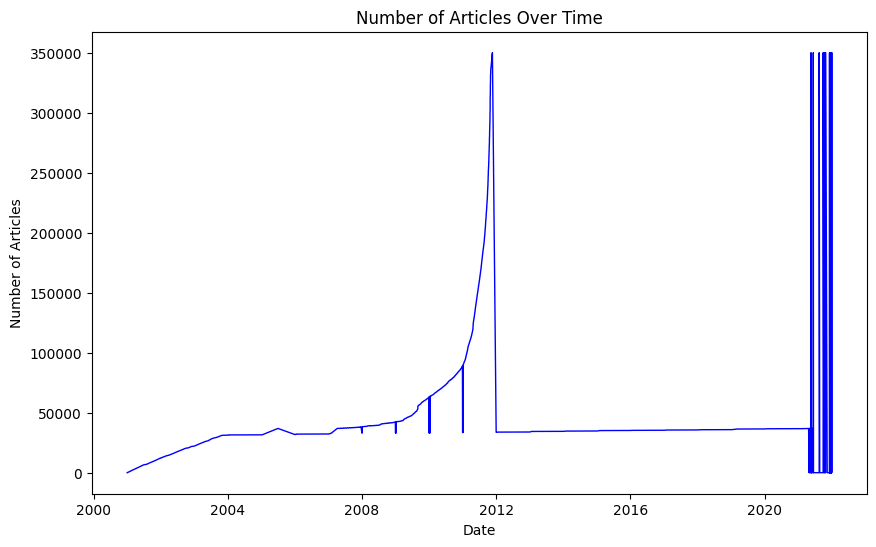

In [ ]:
# Function to visualize the number of articles over time
def plot_articles_over_time(data_df):
    # Assuming the date of the news articles is stored in a column named 'date'
    data_df['date'] = pd.to_datetime(data_df['date'])
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='date', y=data_df.index, data=data_df, estimator=None, lw=1, color='blue')
    plt.title('Number of Articles Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.show()

plot_articles_over_time(news_df)

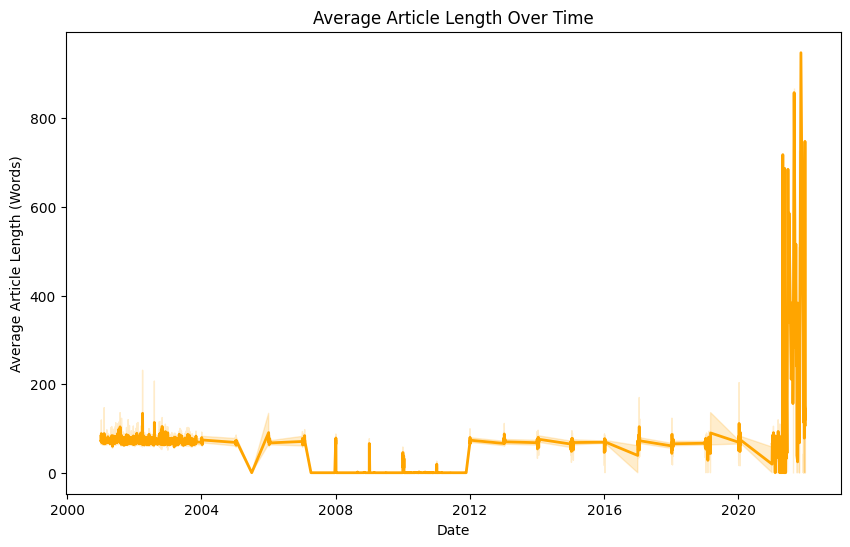

In [ ]:
def plot_avg_article_length_over_time(data_df):
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df['article_length'] = data_df['preprocessed_text'].apply(lambda x: len(x.split()))
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='date', y='article_length', data=data_df, estimator='mean', lw=2, color='orange')
    plt.title('Average Article Length Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Article Length (Words)')
    plt.show()

plot_avg_article_length_over_time(news_df)

In [ ]:
!pip install gensim==4.3.1

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Machine Learning

In this section, we will perform a multi-class classification task using XGBoost, a powerful gradient boosting algorithm, and leverage Word2Vec to convert news articles into meaningful numerical representations suitable for input to XGBoost.

### Leveraging Word2Vec for XGBoost Input

Once we obtain the document-level vectors using Word2Vec, we can use them as features for training the XGBoost model. These numerical representations will provide valuable information to the model, enabling it to make accurate predictions on unseen news articles.

By combining the power of XGBoost and Word2Vec, we aim to create a robust classification system capable of distinguishing the publishers of English and Japanese news articles effectively. The integration of these two techniques allows us to handle the complexities of multiclass classification while leveraging the semantic context of the news articles for improved predictive performance.

### Word2Vec for Text Embeddings

As news articles are typically represented as textual data, we need to convert them into numerical vectors before feeding them into the XGBoost model. Word2Vec, a popular word embedding technique, will help us accomplish this task.

Word2Vec represents words in a dense vector space where semantically similar words are located close together. By applying Word2Vec to the news articles' text, we will create meaningful embeddings that capture the contextual information of each article.

In [ ]:
import pandas as pd
from gensim.models import Word2Vec

def train_word2vec_model(sentences, vector_size=32, window=6, min_count=2, workers=4):
    # Train the Word2Vec model creating 32 feature for each word
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model

def get_document_vectors(df, model):
    # Prepare the text data
    sentences = [text.split() for text in df['preprocessed_text']]

    # Obtain document-level vectors for all documents in the DataFrame
    document_vectors = []
    for document in sentences:
        doc_vector = []
        for word in document:
            try:
                # Try to get the word vector for each word in the document
                word_vector = model.wv[word]
                doc_vector.append(word_vector)
            except KeyError:
                # If the word is not present in the vocabulary, skip it
                continue

        # Calculate the document-level vector by averaging word vectors
        if doc_vector:
            doc_vector = sum(doc_vector) / len(doc_vector)
        else:
            # Handle the case when the document is empty or all words are not present in the vocabulary
            doc_vector = [0.0] * model.vector_size

        document_vectors.append(doc_vector)

    # Convert the list of document vectors into a DataFrame
    document_vectors_df = pd.DataFrame(document_vectors)

    return document_vectors_df


### Data Preprocessing
Let's do some feature engineering and prepare the dataframe for the ML model. 
We make sure the data is the best suited for the downstream process. Removing outliers, scaling numbers properly and one-hot encoding categorical values. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features_df = news_df.drop(['text','title','preprocessed_title','index'], axis=1).copy(deep=True)

features_df['article_length'] = features_df['preprocessed_text'].apply(lambda x: len(x.split()))

features_df['date'] = pd.to_datetime(features_df['date'])
# Set the fixed reference point as January 1, 2000
fixed_reference_point = pd.Timestamp('2000-01-01')
# Calculate the time elapsed since the fixed reference point
features_df['time_elapsed'] = (features_df['date'] - fixed_reference_point).dt.total_seconds()
# Drop the original datetime column as we have converted it to a numeric representation
features_df.drop('date', axis=1, inplace=True)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the selected column
features_df['article_length'] = scaler.fit_transform(features_df[['article_length']])
features_df['time_elapsed'] = scaler.fit_transform(features_df[['time_elapsed']])

features_df['language'] = features_df['language'].map(lambda x: 1 if x == 'English' else 0)

## Perform one-hot encoding on the 'category' column
#one_hot_encoded = pd.get_dummies(features_df['author'])
## Concatenate the one-hot encoded columns with the original DataFrame
#features_df = pd.concat([features_df, one_hot_encoded], axis=1)

features_df.drop('author', axis=1, inplace=True)
features_df.describe()

(349844, 5)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Extract the class labels from the DataFrame
y_labels = features_df['source']
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit the LabelEncoder on the class labels and transform them to numeric representations
features_df['target'] = label_encoder.fit_transform(y_labels)
features_df['target'] = pd.to_numeric(features_df['target'])
# Obtain the mapping of numeric labels to original class labels
class_label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

yyy = features_df['target'].copy(deep=True)
features_df = features_df.drop(['source','target'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_df.copy(deep=True), yyy, test_size=0.25, random_state=42)
# Convert numpy arrays back to DataFrames
X_train_df = pd.DataFrame(X_train, columns=features_df.columns)
X_test_df = pd.DataFrame(X_test, columns=features_df.columns)

# Training the Word2Vec model only with the trainig data
train_sentences = [text.split() for text in X_train_df['preprocessed_text']]
word2vec_model = train_word2vec_model(train_sentences)

# Obtain document vectors for train DataFrame using the trained Word2Vec model
train_document_vectors_df = get_document_vectors(X_train_df, word2vec_model)
# Obtain document vectors for test DataFrame using the same trained Word2Vec model
test_document_vectors_df = get_document_vectors(X_test_df, word2vec_model)


X_train_df = X_train_df.drop('preprocessed_text',axis=1)
X_test_df = X_test_df.drop('preprocessed_text',axis=1)

X_train_pre = pd.concat([X_train_df, train_document_vectors_df], axis=1)
X_test_pre = pd.concat([X_test_df, test_document_vectors_df], axis=1)

# Rename the columns to make them more meaningful
num_dimensions = len(train_document_vectors_df.columns)
column_names = [f'vector_{i}' for i in range(num_dimensions)]
X_train_pre.columns = X_train_df.columns.tolist() + column_names
X_test_pre.columns = X_test_df.columns.tolist() + column_names

X_test_pre.dropna(inplace=True)
X_train_pre.dropna(inplace=True)

# Now the DataFrame contains the original data along with document-level vectors in each row
X_train_pre

['language', 'article_length', 'time_elapsed']


,language,article_length,time_elapsed,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,...,vector_22,vector_23,vector_24,vector_25,vector_26,vector_27,vector_28,vector_29,vector_30,vector_31
1,1.0,0.228301,0.996871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.182349,0.997001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.253100,0.997001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.146608,0.997131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.212983,0.997262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262378,0.0,0.000000,0.513496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262379,0.0,0.000000,0.513496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262380,0.0,0.000000,0.513496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262381,0.0,0.000000,0.513496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Back to numpy arrays
X_train = X_train_df.values
X_test = X_test_df.values

### Baseline
The starting point is always a baseline stupid model to beat. Here we just guess the class based on the frequency we saw in the dataset. 

In [ ]:
import numpy as np

# Calculate the number of classes
num_classes = np.max(y_train) + 1

# Calculate the proportion of each class in the training set
class_proportions = np.bincount(y_train) / len(y_train)

# Generate random predictions for the test set based on the class proportions
random_predictions = np.random.choice(num_classes, size=len(y_test), p=class_proportions)

# Calculate the accuracy of the random baseline model
accuracy_random_baseline = np.mean(y_test == random_predictions)
print("Accuracy of the random baseline:", accuracy_random_baseline)

Accuracy of the random baseline: 0.07968122934793793


### XGBoost for Multi-Class Classification

XGBoost (Extreme Gradient Boosting) is a widely used machine learning algorithm known for its effectiveness in handling complex classification problems. It can handle both binary and multi-class classification tasks efficiently while maintaining high predictive accuracy.

We will utilize XGBoost to classify news articles into one of multiple classes based on their publishers. The goal is to predict the newspaper that published each article, which falls into one of several categories.


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Initialize the XGBoost classifier
clf = xgb.XGBClassifier(
    objective='multi:softmax',  # Specify the objective function for multi-class classification
    num_class=len(class_label_mapping.keys()),
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the classifier on the training data
clf.fit(X_train, y_train)


# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[15:05:19] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weights" } are not used.

Accuracy: 0.39050548244360345


# Deep Learning

In [24]:
from sklearn.preprocessing import LabelEncoder

#Prepare Dataset
ml_df = news_df[['source','text','language']].copy(deep=True).dropna()
ml_df = ml_df.sample(frac=0.03, random_state=42).reset_index(drop=True)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit the LabelEncoder on the class labels and transform them to numeric representations
ml_df['target'] = label_encoder.fit_transform(ml_df['source'])
ml_df['target'] = pd.to_numeric(ml_df['target'])
ml_df = ml_df.drop('source',axis=1)
num_classes = len(ml_df.loc[:,'target'].unique())

ml_df.describe(include='all')

,text,language,target
count,10492,10492,10492.000000
unique,10491,2,NaN
top,The run of young trout up the Tama River this ...,Japanese,NaN
freq,2,9400,NaN
mean,NaN,NaN,10.666794
std,NaN,NaN,5.891879
min,NaN,NaN,0.000000
25%,NaN,NaN,8.000000
50%,NaN,NaN,10.000000
75%,NaN,NaN,15.000000


In [25]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load pre-trained BERT models and tokenizers for English and Japanese
english_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
english_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

japanese_model = BertForSequenceClassification.from_pretrained('cl-tohoku/bert-base-japanese-v3', num_labels=num_classes)
japanese_tokenizer = BertTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3')

# Define the optimizer and learning rate for both models
optimizer_en = AdamW(english_model.parameters(), lr=2e-5)
optimizer_ja = AdamW(japanese_model.parameters(), lr=2e-5)

# Tokenize and preprocess the text data with the appropriate tokenizer based on the language
def preprocess_text(text_data, language, max_length, tokenizer_en, tokenizer_ja):
    input_ids = []
    attention_masks = []

    for text, lang in zip(text_data, language):
        if lang == 'English':  # English
            encoded = tokenizer_en.encode_plus(text, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
        elif lang == 'Japanese':  # Japanese
            encoded = tokenizer_ja.encode_plus(text, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_tensors='pt')
        else:
            raise ValueError("Unsupported language:", lang)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return input_ids, attention_masks

# Prepare data for PyTorch DataLoader
def create_data_loader(input_ids, attention_masks, labels, batch_size):
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    labels = torch.tensor(labels)

    data = TensorDataset(input_ids, attention_masks, labels)
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

    return data_loader

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.
/Users/stefano/Experiments/ingcrypto/ml-notebook/.venv/lib/python3.9/site-packages/transformers/optimizat

In [26]:
# Example usage with DataFrame split
max_length = 128
batch_size = 64

# Assuming you have already loaded your DataFrame 'df'
# Split the DataFrame into train, validation, and test sets
train_data, temp_data = train_test_split(ml_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Preprocess text for train, validation, and test data
train_input_ids, train_attention_masks = preprocess_text(train_data['text'], train_data['language'], max_length, english_tokenizer, japanese_tokenizer)
val_input_ids, val_attention_masks = preprocess_text(val_data['text'], val_data['language'], max_length, english_tokenizer, japanese_tokenizer)
test_input_ids, test_attention_masks = preprocess_text(test_data['text'], test_data['language'], max_length, english_tokenizer, japanese_tokenizer)

print("preprocessing DONE")

preprocessing DONE


In [27]:
# Convert input_ids and attention_masks to PyTorch tensors
train_input_ids = torch.stack(train_input_ids)
train_attention_masks = torch.stack(train_attention_masks)

val_input_ids = torch.stack(val_input_ids)
val_attention_masks = torch.stack(val_attention_masks)

test_input_ids = torch.stack(test_input_ids)
test_attention_masks = torch.stack(test_attention_masks)

# Convert target labels to a 1D array (list or pandas Series)
train_labels = train_data['target'].values
val_labels = val_data['target'].values
test_labels = test_data['target'].values

# Create data loaders for train, validation, and test sets
train_data_loader = DataLoader(TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_labels)), batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_labels)), batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(TensorDataset(test_input_ids, test_attention_masks, torch.tensor(test_labels)), batch_size=batch_size, shuffle=False)

In [28]:
# Fine-tuning for English texts
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
english_model.to(device)
num_epochs = 2

for epoch in range(num_epochs):
    english_model.train()
    for batch in train_data_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.squeeze()
        attention_masks = attention_masks.squeeze()
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        # Identify the language of each text in the batch
        languages = train_data.iloc[input_ids[:, 0]]['language']
        # Mask to extract English inputs
        mask = torch.tensor((languages == 'English').to_numpy())
        assert mask.dim() == 1 and mask.size(0) == input_ids.size(0), "Mask size does not match input_ids size"
        # Check if there are any English samples in the batch before proceeding
        if mask.any():
            input_ids_en = input_ids[mask]
            attention_masks_en = attention_masks[mask]
            labels_en = labels[mask]

            outputs = english_model(input_ids_en, attention_mask=attention_masks_en, labels=labels_en)
            loss = outputs.loss
            loss.backward()
            optimizer_en.step()
            optimizer_en.zero_grad()
    # Validation after each epoch
    print("Validation!!!!!!!!!!!!!!!!!")
    english_model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        correct_predictions = 0

        for batch in val_data_loader:
            input_ids, attention_masks, labels = batch
            input_ids = input_ids.squeeze()
            attention_masks = attention_masks.squeeze()
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            # Identify the language of each text in the batch
            languages = val_data.iloc[input_ids[:, 0]]['language']
            # Mask to extract English inputs
            mask = torch.tensor((languages == 'English').to_numpy())
            assert mask.dim() == 1 and mask.size(0) == input_ids.size(0), "Mask size does not match input_ids size"
            # Check if there are any English samples in the batch before proceeding
            if mask.any():
                input_ids_en = input_ids[mask]
                attention_masks_en = attention_masks[mask]
                labels_en = labels[mask]

                outputs = english_model(input_ids_en, attention_mask=attention_masks_en, labels=labels_en)
                val_loss = outputs.loss
                total_val_loss += val_loss.item()

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                correct_predictions += (predictions == labels_en).sum().item()

        val_accuracy = correct_predictions / len(val_data_loader.dataset)
        avg_val_loss = total_val_loss / len(val_data_loader)

        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



Validation!!!!!!!!!!!!!!!!!
Epoch 1/2 - Validation Loss: 0.0000, Validation Accuracy: 0.0000
Validation!!!!!!!!!!!!!!!!!
Epoch 2/2 - Validation Loss: 0.0000, Validation Accuracy: 0.0000


In [29]:
# Fine-tuning for Japanese texts
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
japanese_model.to(device)
num_epochs = 1

for epoch in range(num_epochs):
    japanese_model.train()
    for batch in train_data_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.squeeze()
        attention_masks = attention_masks.squeeze()
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        # Identify the language of each text in the batch
        languages = train_data.iloc[input_ids[:, 0]]['language']
        # Mask to extract English inputs
        mask = torch.tensor((languages == 'Japanese').to_numpy())
        assert mask.dim() == 1 and mask.size(0) == input_ids.size(0), "Mask size does not match input_ids size"
        input_ids_ja = input_ids[mask]
        attention_masks_ja = attention_masks[mask]
        labels_ja = labels[mask]

        outputs = japanese_model(input_ids_ja, attention_mask=attention_masks_ja, labels=labels_ja)
        loss = outputs.loss
        loss.backward()
        optimizer_en.step()
        optimizer_en.zero_grad()

    # Validation after each epoch
    japanese_model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        correct_predictions = 0

        for batch in val_data_loader:
            input_ids, attention_masks, labels = batch
            input_ids = input_ids.squeeze()
            attention_masks = attention_masks.squeeze()
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            # Identify the language of each text in the batch
            languages = val_data.iloc[input_ids[:, 0]]['language']
            # Mask to extract English inputs
            mask = torch.tensor((languages == 'Japanese').to_numpy())
            assert mask.dim() == 1 and mask.size(0) == input_ids.size(0), "Mask size does not match input_ids size"
            input_ids_ja = input_ids[mask]
            attention_masks_ja = attention_masks[mask]
            labels_ja = labels[mask]

            outputs = japanese_model(input_ids_ja, attention_mask=attention_masks_ja, labels=labels_ja)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels_ja).sum().item()

        val_accuracy = correct_predictions / len(val_data_loader.dataset)
        avg_val_loss = total_val_loss / len(val_data_loader)

        print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/1 - Validation Loss: 3.1204, Validation Accuracy: 0.0311


In [30]:
# Evaluation on the test set after training
english_model.eval()
japanese_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    total_test_loss_en = 0.0
    total_test_loss_ja = 0.0
    correct_predictions_en = 0
    correct_predictions_ja = 0

    for batch in test_data_loader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.squeeze()
        attention_masks = attention_masks.squeeze()
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)


        # Identify the language of each text in the batch
        languages = train_data.iloc[input_ids[:, 0]]['language']
        # Mask to extract English inputs
        mask_ja = torch.tensor((languages == 'Japanese').to_numpy())
        mask_en = torch.tensor((languages == 'English').to_numpy())

        # Separate the input data into English and Japanese texts
        input_ids_en = input_ids[mask_en]
        attention_masks_en = attention_masks[mask_en]
        labels_en = labels[mask_en]

        input_ids_ja = input_ids[mask_ja]
        attention_masks_ja = attention_masks[mask_ja]
        labels_ja = labels[mask_ja]

        # Test English texts using english_model
        if len(input_ids_en) > 0:
            outputs_en = english_model(input_ids_en, attention_mask=attention_masks_en, labels=labels_en)
            test_loss_en = outputs_en.loss
            total_test_loss_en += test_loss_en.item()

            logits_en = outputs_en.logits
            predictions_en = torch.argmax(logits_en, dim=1)
            correct_predictions_en += (predictions_en == labels_en).sum().item()

        # Test Japanese texts using japanese_model
        if len(input_ids_ja) > 0:
            outputs_ja = japanese_model(input_ids_ja, attention_mask=attention_masks_ja, labels=labels_ja)
            test_loss_ja = outputs_ja.loss
            total_test_loss_ja += test_loss_ja.item()

            logits_ja = outputs_ja.logits
            predictions_ja = torch.argmax(logits_ja, dim=1)
            correct_predictions_ja += (predictions_ja == labels_ja).sum().item()

    test_accuracy_en = correct_predictions_en / len(test_data[test_data['language'] == 'English'])
    test_accuracy_ja = correct_predictions_ja / len(test_data[test_data['language'] == 'Japanese'])

    avg_test_loss_en = total_test_loss_en / len(test_data[test_data['language'] == 'English'])
    avg_test_loss_ja = total_test_loss_ja / len(test_data[test_data['language'] == 'Japanese'])

    print(f"English Test Loss: {avg_test_loss_en:.4f}, English Test Accuracy: {test_accuracy_en:.4f}")
    print(f"Japanese Test Loss: {avg_test_loss_ja:.4f}, Japanese Test Accuracy: {test_accuracy_ja:.4f}")


English Test Loss: 0.0000, English Test Accuracy: 0.0000
Japanese Test Loss: 0.0553, Japanese Test Accuracy: 0.0248
